# Point Cloud-to-Simplicial Ball Pivoting Lifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, createsa a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

## Imports and utilities

In [1]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import SpherePointCloudLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load Dataset

We will now load the toy dataset on which we have validated our algorithm. The name of the dataset config is sphere_point_cloud.


Dataset configuration for sphere_point_cloud:

{'data_domain': 'pointcloud',
 'data_type': 'toy_dataset',
 'data_name': 'sphere_point_cloud',
 'num_features': 1,
 'num_classes': 2,
 'data_dir': 'datasets/pointcloud/toy_dataset'}


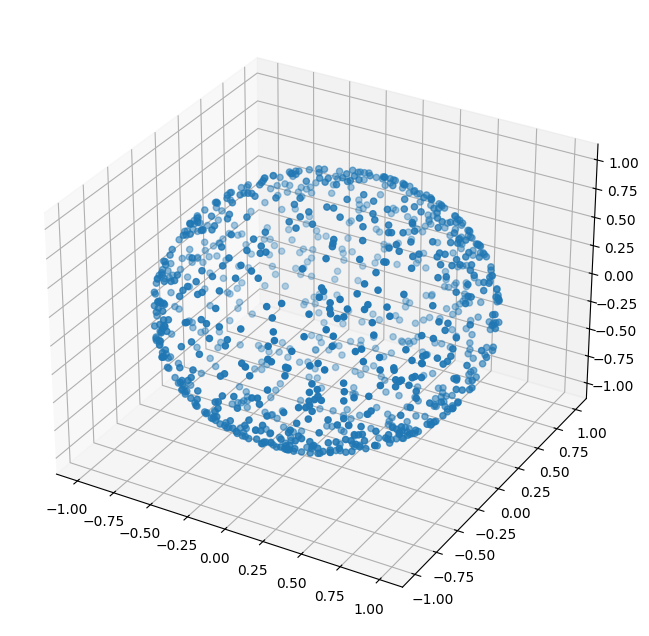

In [8]:
dataset_name = "sphere_point_cloud"
dataset_config = load_dataset_config(dataset_name)
loader = SpherePointCloudLoader(dataset_config)

dataset = loader.load()
loader.plot_point(dataset)
# describe_data(dataset)

## Ball Pivoting Lifting Tutorial

The ball pivoting lifting reconstructs surfaces from oriented point cloud data sets. The algorithm works by, at initialization, selecting three points at random to form a triangle (note, all three points must fall within a ball of radius r (specified by the user), while no other points fall within the same ball). Once this triangle has been formed, a ball of radius r is rolled along the edges of the triangle. If a point falls within the this ball during its rolling (and when no other points are within the ball), a new triangle is added where the new point is a vertex in the triangle. This process is continued until all reachable edges have been tried. A new seed triangle is picked and the process is restarted until all points in the point cloud have been reached. For a more in-depth look at the algorithm, see the following reference. 

***
[[1]](http://mesh.brown.edu/taubin/pdfs/bernardini-etal-tvcg99.pdf) F. Bernardini, J. Mittleman, H. Rushmeier, C. Silva and G. Taubin, "The ball-pivoting algorithm for surface reconstruction," in IEEE Transactions on Visualization and Computer Graphics, vol. 5, no. 4, pp. 349-359, Oct.-Dec. 1999, doi: 10.1109/2945.817351.

***





In [5]:
from modules.transforms.liftings.pointcloud2simplicial.ball_pivoting_lifting import BallPivotingLifting

# NOTE: if you want to see an image of the surface reconstruction, you must run this cell. 
# A pop-up window with the reconstructed surfarce will appear. 
# Unfortunately, open3d's plotting features do not embed into the Jupyter notebook.

# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "pointcloud2simplical/ball_pivoting_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}

lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

# Plot the surface reconstruction - see note at the top of this cell
lifting_temp = BallPivotingLifting(radii=transform_config["lifting"]["radii"])
lifting_temp.plot_lifted_topology(data=dataset)


Transform configuration for pointcloud2simplical/ball_pivoting_lifting:

{'transform_type': 'lifting',
 'transform_name': 'BallPivotingLifting',
 'radii': [0.1, 0.5],
 'feature_lifting': 'ProjectionSum'}
Transform parameters are the same, using existing data_dir: C:\Source\OtherProjects\ICML2024Challenge\challenge-icml-2024\datasets/pointcloud/toy_dataset\sphere_point_cloud\lifting\3601363654

Dataset only contains 1 sample:
 - The complex has 1000 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 2994 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 1996 2-cells.
 - The 2-cells have features dimension 1



## Create and Run a Simplicial NN Model

In this section a simple model is created to test that the used lifting works as intended.

In [3]:
from modules.models.simplicial.san import SANModel

model_type = "simplicial"
model_id = "san"
model_config = load_model_config(model_type, model_id)

model = SANModel(model_config, dataset_config)


Model configuration for simplicial SAN:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2,
 'n_filters': 2,
 'order_harmonic': 5,
 'epsilon_harmonic': 0.1}


In [6]:
y_hat = model(lifted_dataset.get(0))